# Welcome to the Berkeley Lab Bottom-Up (LBL-BU) Price-Responsive Home-Automation Demand-Respose Framework

Please adjust the following parameters as you wish,
or just run the examples.

## Parameters to adjust

### Customer Data / Demand Profiles

Please select a folder that includes a file cluster_summary.csv that describes the customer clusters
regarding specific criteria (sector, IOT (util), buidling_type, LCA, climate, size, ...).

Parameters: 
* Year (2025, 2030)
* Weather Year (1in2, 1in10)
* Demand Increase (midDemand, highDemand, lowDemand)

`cluster_input_folder = "/mnt/sdb/phase4_inputs/forecasted_load/non_anonymized-1in10-midDemand-with_EE_FS-2030/"`

### Otherwise Applicable Tariffs

Please provide a mapping between customer clusters (CC) and otherwise applicable tariffs (OAT) 
and the OAT files in the OpenEI json format.

This mapping is used to determine the OAT for each individual CC.

Parameters:
```
{ 
    'filter_PGE_com_B-1': {
        'filters': [
            ('util', 'equals', 'pge'), 
            ('sector', 'equals', 'com'), 
            ('ts_kw_ann_peak', '<', '75')
        ], 'tou_rate': 'B-1'},
    'filter_PGE_com_B-10': {
        'filters': [
            ('util', 'equals', 'pge'), 
            ('sector', 'equals', 'com'), 
            ('ts_kw_ann_peak', '>=', '75'),
            ('ts_kw_ann_peak', '<',  '200'),
        ], 'tou_rate': 'B-10'},
     ...
}
```

### Dynamic Rate

The dynamic rate is calculated as a function of
* the wholesale price
* system level net load
* system level gross load
* original utility revenue per price component
* original utility revenue per customer cluster
* a complex iteration scheme that estimates response to the price and then calculates a new price

Please provide the path the to dynamic rate
`wholesale_price_location = /mnt/sdb/dynamic_pricing/tariffs/PGE_2018-2019.csv`
`dynamic_rate_location = /mnt/sdb/dynamic_pricing/tariffs/PGE_2018-2019.csv`
`utility_revenue_location = /mnt/sdb/dynamic_pricing/tariffs/PGE_2018-2019.csv`
`system_level_loads_location = /mnt/sdb/dynamic_pricing/tariffs/PGE_2018-2019.csv`
`iteration_max = 1`


### Enduses and Technology Definitions

```
[
    { 
        'technology': 'HPWH',
        'enduse': 'water_heating',
        'rte': .9,
        'shift_window': 3,
        'base_load_frac': .25,
        'shift_direction': 'before',
        'storage_capacity': '100',
        'storage_loss_per_hour': '50%'
    }
]
```

### Weather and Building Envelope

```
[
    {
        'name': 'building_com',
        'filters': [
            ('util', 'equals', 'pge'), 
            ('sector', 'equals', 'com'), 
            ('enduse', 'equals', 'water_heating')
        ], 
        'storage_loss_hourly_frac': .5,
    },
    {
        'name': 'building_res',
        'filters': [
            ('util', 'equals', 'pge'), 
            ('sector', 'equals', 'res'), 
            ('enduse', 'equals', 'water_heating')
        ], 
        'storage_loss_hourly_file_8760': 
            '/mnt/sdb/dynamic_pricing/building_shell/res_thermal_loss_8760.csv',
    },
]
```

In [2]:
# Customer Data / Demand Profiles
cluster_input_folder = "/mnt/sdb/phase4_inputs/forecasted_load/non_anonymized-1in10-midDemand-with_EE_FS-2030/"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#############################################################################
import pandas as pd
import numpy as np
from pdb import set_trace as bp
import os

import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from datetime import datetime
from datetime import timedelta 
from datetime import datetime as dt

import seaborn as sns



sys.path.append('../../cpuc-dynamic-pricing/')
sys.path.append('../../cpuc-dynamic-pricing/cpuc_dynamic_pricing/')
from Dot_Progress_Bar import Dot_Progress_Bar

In [5]:
cluster_summary_path = cluster_input_folder+"cluster_summary.csv"
cluster_summary = pd.read_csv(cluster_summary_path)

print('{} clusters loaded.'.format(len(cluster_summary)))

5434 clusters loaded.


In [6]:
cl_df = dict()
i = 0
for row in cluster_summary.iterrows():
    cluster = row[1]['name']
    cl_df[cluster] = pd.read_csv(cluster_input_folder + cluster + '.csv')
    if 'water_heating' in cl_df[cluster].columns and i > 250:
        break
    i += 1
    print('.', end='')

...........................................................................................................................................................................................................................................................

In [26]:
day_slice = slice(24*90,24*91)

one_day = cl_df[cluster].iloc[day_slice]

In [27]:
one_day

,hour_ending,cooking,dishwasher,dryer,freezer,ventilation,indoor_lighting,other,pool_pump,refrigeration,...,outdoor_lighting,water_heating,office_equipment,pc,ev_level1,ev_level2,heating,cooling,total,pv_generation
2160,2161,1.269877,0.605114,1.565615,4.798115,0.975876,15.159281,44.066731,2.571262,34.332584,...,4.415348,6.115904,0.311389,7.871979,1.585464,1.325189,40.320863,0.000000,177.861410,0.0
2161,2162,1.338209,0.423435,1.034153,5.220054,1.078064,12.824301,47.742130,3.306150,36.807622,...,3.735253,5.060883,0.337360,8.528543,1.583250,0.976228,45.132660,0.000000,183.215802,0.0
2162,2163,1.535404,0.272836,0.701046,5.605272,1.331896,11.690689,51.293025,3.479034,39.352536,...,3.405073,5.192709,0.362452,9.162867,1.498600,0.673483,53.836038,0.000000,194.701763,0.0
2163,2164,1.986420,0.270306,0.737160,5.659397,1.650245,10.892153,52.614677,3.461375,39.809560,...,3.172489,5.389542,0.371791,9.398964,1.312726,0.370171,57.641556,0.000000,199.603686,0.0
2164,2165,2.414856,0.372307,0.924716,5.096631,1.941190,10.270878,48.728654,3.135521,35.853056,...,2.991534,5.386124,0.344331,8.704774,0.966119,0.181582,53.423459,0.000000,185.660516,0.0
2165,2166,3.696714,0.833935,2.044731,5.744416,2.842793,14.234633,56.487905,3.824892,40.513886,...,4.146032,7.106094,0.399160,10.090868,0.820853,0.161977,57.400340,0.000000,217.111442,0.0
2166,2167,8.992654,2.554434,6.608398,9.692295,5.699005,30.679600,96.468240,7.032200,67.470528,...,8.935854,17.858113,0.681673,17.232863,0.922011,0.300565,53.629048,0.000000,346.884408,0.0
2167,2168,17.797152,5.253958,15.378222,13.058561,8.050514,48.189894,130.560373,11.095392,91.967747,...,14.035966,37.575446,0.922579,23.323002,0.864965,0.651122,36.838918,0.000000,474.602988,0.0
2168,2169,16.083274,4.949129,17.025717,9.808274,5.510405,37.303579,96.287515,9.977997,69.752146,...,10.865178,35.915349,0.680396,17.200578,0.507154,0.571304,28.352417,0.000000,378.849486,0.0
2169,2170,15.377827,4.913560,20.107501,9.212174,4.189692,33.364359,87.398026,10.553979,65.853044,...,9.717827,33.360183,0.617581,15.612581,0.421756,0.650041,21.643489,0.000000,353.564951,0.0


In [28]:
one_day

,hour_ending,cooking,dishwasher,dryer,freezer,ventilation,indoor_lighting,other,pool_pump,refrigeration,...,outdoor_lighting,water_heating,office_equipment,pc,ev_level1,ev_level2,heating,cooling,total,pv_generation
2160,2161,1.269877,0.605114,1.565615,4.798115,0.975876,15.159281,44.066731,2.571262,34.332584,...,4.415348,6.115904,0.311389,7.871979,1.585464,1.325189,40.320863,0.000000,177.861410,0.0
2161,2162,1.338209,0.423435,1.034153,5.220054,1.078064,12.824301,47.742130,3.306150,36.807622,...,3.735253,5.060883,0.337360,8.528543,1.583250,0.976228,45.132660,0.000000,183.215802,0.0
2162,2163,1.535404,0.272836,0.701046,5.605272,1.331896,11.690689,51.293025,3.479034,39.352536,...,3.405073,5.192709,0.362452,9.162867,1.498600,0.673483,53.836038,0.000000,194.701763,0.0
2163,2164,1.986420,0.270306,0.737160,5.659397,1.650245,10.892153,52.614677,3.461375,39.809560,...,3.172489,5.389542,0.371791,9.398964,1.312726,0.370171,57.641556,0.000000,199.603686,0.0
2164,2165,2.414856,0.372307,0.924716,5.096631,1.941190,10.270878,48.728654,3.135521,35.853056,...,2.991534,5.386124,0.344331,8.704774,0.966119,0.181582,53.423459,0.000000,185.660516,0.0
2165,2166,3.696714,0.833935,2.044731,5.744416,2.842793,14.234633,56.487905,3.824892,40.513886,...,4.146032,7.106094,0.399160,10.090868,0.820853,0.161977,57.400340,0.000000,217.111442,0.0
2166,2167,8.992654,2.554434,6.608398,9.692295,5.699005,30.679600,96.468240,7.032200,67.470528,...,8.935854,17.858113,0.681673,17.232863,0.922011,0.300565,53.629048,0.000000,346.884408,0.0
2167,2168,17.797152,5.253958,15.378222,13.058561,8.050514,48.189894,130.560373,11.095392,91.967747,...,14.035966,37.575446,0.922579,23.323002,0.864965,0.651122,36.838918,0.000000,474.602988,0.0
2168,2169,16.083274,4.949129,17.025717,9.808274,5.510405,37.303579,96.287515,9.977997,69.752146,...,10.865178,35.915349,0.680396,17.200578,0.507154,0.571304,28.352417,0.000000,378.849486,0.0
2169,2170,15.377827,4.913560,20.107501,9.212174,4.189692,33.364359,87.398026,10.553979,65.853044,...,9.717827,33.360183,0.617581,15.612581,0.421756,0.650041,21.643489,0.000000,353.564951,0.0


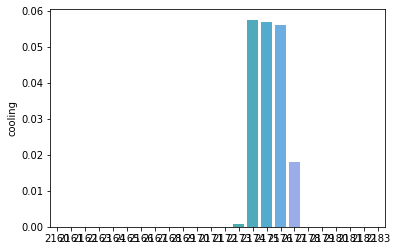

In [29]:
sns.barplot(data=one_day, y='cooling', x=one_day.index)
plt.show()


In [58]:
tech = {
    'rte': .9,
    'shift_window': 3,
    'base_load_frac': .25,
    'shift_direction': 'before',
}

RteDefinitionConstant = {
    'type': 'fractional-constant',
    'value': .9
}

import random
random.seed(876000001234)
RteDefinition8760 = {
    'type': 'fractional-8760',
    'value': [random.randint(50, 90) / 100 for x in range(0, 8760)]
    # This simulates the weather
}


#restrictions
#   'max_load': per enduse the maximum demand
#        
#        Empirical values per enduse / technology

In [46]:
price = pd.read_csv('/mnt/sdb/dynamic_pricing/tariffs/PGE_2018-2019.csv')[-8760:].reset_index(drop=True)
display(price.head())
display(price[day_slice].head())

,Fixed_Volumetric,Other_FCR,Del_FCR,Gen_FCR,Flex_FCR,Wholesale,Losses,Total
0,0.0,0.143284,0.010423,0.008049,0.0,0.042429,0.002866,0.207051
1,0.0,0.136713,0.009322,0.006887,0.0,0.041110,0.002590,0.196621
2,0.0,0.129649,0.008527,0.005710,0.0,0.039773,0.002373,0.186032
3,0.0,0.125565,0.008143,0.005067,0.0,0.039372,0.002284,0.180431
4,0.0,0.126605,0.008239,0.005228,0.0,0.040475,0.002365,0.182913


,Fixed_Volumetric,Other_FCR,Del_FCR,Gen_FCR,Flex_FCR,Wholesale,Losses,Total
912,0.0,0.185796,0.009820,0.016893,0.000000,0.155427,0.010114,0.378050
913,0.0,0.177377,0.009439,0.014982,0.000000,0.150752,0.009572,0.362122
914,0.0,0.174086,0.009328,0.014254,0.000000,0.143300,0.009032,0.350000
915,0.0,0.174039,0.009335,0.014244,0.000000,0.142280,0.008972,0.348869
916,0.0,0.186406,0.010354,0.017034,0.000196,0.151796,0.010211,0.375997


In [47]:
def select_cluster_and_day(cl_df):
    for cluster, df in cl_df.items():
        print('.', end='')
        if 'water_heating' not in df.columns:
            continue
        for day in range(0, 365):
            day_slice = slice(day*24, (day + 1)*24)
            if df.loc[day_slice, 'heating'].min() == 0:
                continue
            if df.loc[day_slice, 'cooling'].max() < 0.01:
                continue
            
            return cluster, day_slice
        

cluster, day_slice = select_cluster_and_day(cl_df)
print(cluster, day_slice)

one_day = cl_df[cluster][day_slice]

# TODO: Select a cluster from each loadshape (clustered by Sam)



...................................res-sdge-mult_fam-allSize-hot_dry-Care-NoLCA-NiteFlat+Flat-0_20pct slice(912, 936, None)


res-sdge-mult_fam-allSize-hot_dry-Care-NoLCA-NiteFlat+Flat-0_20pct


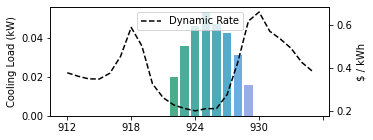

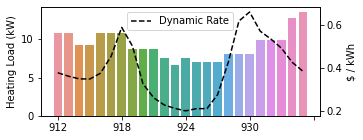

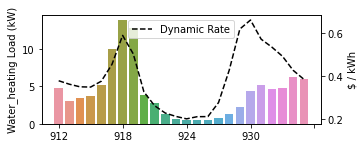

In [48]:
def plot_load_vs_price(cluster, day_slice, enduse):
    ts = cl_df[cluster][day_slice]
    if enduse not in ts.columns:
        return
        
    plt.figure(figsize=(5,2))
    ax = sns.barplot(data=ts, y=enduse, x=one_day.index)

    ax.set_ylabel(f'{enduse.capitalize()} Load (kW)')
    ax2 = ax.twinx()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(6))

    plt.gcf().patch.set_facecolor('white')

    sns.lineplot(data=price[day_slice], x=range(0,24), y='Total', ax=ax2, label='Dynamic Rate', color='black', linestyle='dashed')
    ax2.set_ylabel('$ / kWh')

    plt.show()


print(cluster)
for enduse in ['cooling', 'heating', 'water_heating']:
     plot_load_vs_price(cluster, day_slice, enduse)
            
            
            

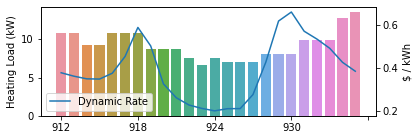

In [34]:
plt.figure(figsize=(6,2))
ax = sns.barplot(data=one_day, y='heating', x=one_day.index)

ax.set_ylabel('Heating Load (kW)')
ax2 = ax.twinx()
ax.xaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.MultipleLocator(6))

sns.lineplot(data=price[day_slice], x=range(0,24), y='Total', ax=ax2, label='Dynamic Rate')
ax2.set_ylabel('$ / kWh')

plt.gcf().patch.set_facecolor('white')

plt.show()


In [35]:
print(one_day.index)
one_day
print(price[day_slice].index)

RangeIndex(start=912, stop=936, step=1)
RangeIndex(start=912, stop=936, step=1)


In [36]:
print(price)

      Fixed_Volumetric  Other_FCR   Del_FCR   Gen_FCR  Flex_FCR  Wholesale  \
0                  0.0   0.143284  0.010423  0.008049  0.000000   0.042429   
1                  0.0   0.136713  0.009322  0.006887  0.000000   0.041110   
2                  0.0   0.129649  0.008527  0.005710  0.000000   0.039773   
3                  0.0   0.125565  0.008143  0.005067  0.000000   0.039372   
4                  0.0   0.126605  0.008239  0.005228  0.000000   0.040475   
...                ...        ...       ...       ...       ...        ...   
8755               0.0   0.255751  0.018691  0.035052  0.002763   0.046317   
8756               0.0   0.239060  0.016625  0.030400  0.000000   0.043399   
8757               0.0   0.223828  0.014876  0.026315  0.000000   0.040392   
8758               0.0   0.207249  0.013521  0.022061  0.000000   0.040398   
8759               0.0   0.191326  0.012441  0.018186  0.000000   0.038814   

        Losses     Total  
0     0.002866  0.207051  
1     0.0

In [49]:
def plot_current_action(one_day, shift_schedule, enduse, take_hour, shed_hour, price, balance_take_shed = False):
    plt.figure(figsize=(5,2))
    before_after = shift_schedule.copy()[['take', 'final', 'shed', 'hour']]
    before_after['shed'] = -1 * before_after['shed']
    
    if balance_take_shed:
        c_shed_larger_take = before_after['shed'] > before_after['take']
        before_after.loc[c_shed_larger_take, 'shed'] -= before_after.loc[c_shed_larger_take, 'take']
        before_after.loc[c_shed_larger_take, 'take'] = 0

        c_take_larger_shed = before_after['shed'] < before_after['take']
        before_after.loc[c_take_larger_shed, 'take'] -= before_after.loc[c_take_larger_shed, 'shed']
        before_after.loc[c_take_larger_shed, 'shed'] = 0

    #display(before_after)
    if balance_take_shed:
        before_after['final'] -= before_after['take']
        ax = before_after[['final',  'take', 'shed', 'hour']].plot.bar(stacked=True, x='hour', color=['#1f77b4', '#ff7f0e', '#2ca02c'], ax=plt.gca())
        before_after['final2'] = before_after['final'] + before_after['take']
        before_after['orig2'] = before_after['final'] + before_after['shed']
        #ax.fill_between(range(0,24), before_after['final2'], 0, where=0 < before_after['final2'], facecolor='gold', interpolate=True)
        #ax.fill_between(range(0,24), before_after['orig2'], 0, where=0 < before_after['orig2'], facecolor='#33ffaa', interpolate=True)
        ax.fill_between(range(0,24), before_after['final'], 0, where=0 < before_after['final'], facecolor='#3fa7d4', interpolate=True)
        sns.lineplot(data=before_after, x=range(0,24), y='final2', color='gold')
        sns.lineplot(data=before_after, x=range(0,24), y='orig2', color='#3fa7d4', linewidth=3)
        sns.lineplot(data=before_after, x=range(0,24), y='final', color='#33ffaa')
        #'#1f77b4', '#ff7f0e'
    else:
        before_after['final'] -= before_after['shed']
        before_after['shed'] = -1 * before_after['shed']
        #ax = before_after[['final',  'take', 'shed', 'hour']].plot.bar(x='hour', )
        melted = before_after.melt('hour', var_name='type', value_name='value')
        #display(melted)
        ax = sns.barplot(data=melted, y='value', x='hour', hue='type')

    ax.set_ylabel(f'{enduse.capitalize()} Load (kW)')
    plt.gca().legend(loc='lower right')
    ax2 = ax.twinx()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(6))
    #ax.legend(loc='upper left', bbox_anchor=(1.01,1))
    #ax.legend(loc='upper left')
    
    sns.lineplot(data=price[day_slice], x=range(0,24), y='Total', ax=ax2, label='Dynamic Rate', color='black', linestyle='dashed')
    ax2.set_ylabel('$ / kWh')

    plt.gcf().patch.set_facecolor('white')
    plt.gca().legend(loc='lower left')

    plt.show()
    

In [115]:
def cost_analysis(one_day, shift_schedule, enduse, price):
    before_after = shift_schedule.copy()[['orig', 'take', 'final', 'shed', 'hour']]
    before_after['shed'] = -1 * before_after['shed']
    before_after['Cost_Orig'] = before_after['orig'] * price.loc[one_day.index].reset_index()['Total']
    before_after['Cost_Final'] = before_after['final'] * price.loc[one_day.index].reset_index()['Total']
    before_after['Cost_Diff'] = before_after['Cost_Final'].cumsum() - before_after['Cost_Orig'].cumsum()
    before_after['Load_Diff'] = before_after['final'].cumsum() - before_after['orig'].cumsum()
    return before_after

In [116]:
def plot_cost(one_day, shift_schedule, enduse, price):
    before_after = cost_analysis(one_day, shift_schedule, enduse, price)
    
    before_after = shift_schedule.copy()[['orig', 'take', 'final', 'shed', 'hour']]
    before_after['shed'] = -1 * before_after['shed']
    before_after['Cost_Orig'] = before_after['orig'] * price.loc[one_day.index].reset_index()['Total']
    before_after['Cost_Final'] = before_after['final'] * price.loc[one_day.index].reset_index()['Total']
    before_after['Cost_Diff'] = before_after['Cost_Final'].cumsum() - before_after['Cost_Orig'].cumsum()
    before_after['Load_Diff'] = before_after['final'].cumsum() - before_after['orig'].cumsum()
    
    plt.figure(figsize=(5,2))
    plt.gcf().patch.set_facecolor('white')
    
    sns.lineplot(data=before_after, x=range(0,24), y='Cost_Final', color='gold', label='Final Costs')
    sns.lineplot(data=before_after, x=range(0,24), y='Cost_Orig', color='green', label='Original Costs')
    sns.lineplot(data=before_after, x=range(0,24), y='Cost_Diff', color='darkblue', label='Bill Diff')
    sns.lineplot(data=before_after, x=range(0,24), y='Load_Diff', color='orange', label='Load Diff', linestyle='dashed')
    
    plt.gca().legend(loc='lower left')
    
    plt.show()
    
    display(before_after)
    
    return cost_analysis
    

In [142]:
from Tech_Models.basicshifter import Basic_Shifter

# optimizing_strategy1 is reverse loop
#print(day_slice)
#print(day_slice.stop)

take_hour = 0
shed_hour = 0

enduse = 'cooling'
for enduse in ['cooling', 'heating', 'water_heating']:
    shift_schedule = Basic_Shifter.get_shift_schedule(one_day, day_slice, enduse, tech, price)
    
    schedule_to_plot = shift_schedule.melt('hour', var_name='type', value_name='value')


    plot_load_vs_price(cluster, day_slice, enduse)
    plot_current_action(one_day, shift_schedule, enduse, take_hour, shed_hour, price)
    plot_current_action(one_day, shift_schedule, enduse, take_hour, shed_hour, price, balance_take_shed=True)
    plot_cost(one_day, shift_schedule, enduse, price)

KeyError: 23

In [52]:
schedule_to_plot = shift_schedule.melt('hour', var_name='type', value_name='value')
#schedule_to_plot.index = schedule_to_plot.hour

In [53]:
schedule_to_plot

,hour,type,value
0,912,orig,4.724952
1,913,orig,3.114193
2,914,orig,3.408502
3,915,orig,3.704180
4,916,orig,5.205608
...,...,...,...
91,931,final,3.912512
92,932,final,4.712088
93,933,final,4.744774
94,934,final,6.217424


{20: 1.7000000000000002, 21: 0.8}

{19: 1.9000000000000001, 20: 0.8}

{18: 1.9000000000000001, 19: 1.0}

{17: 1.9000000000000001, 18: 1.0, 19: 0.09999999999999998}

{16: 1.7000000000000002, 17: 0.8}

{15: 1.7000000000000002, 16: 0.8}

{14: 0.7000000000000002, 15: 0.8}

{13: 0.7000000000000002}

{12: 0.7000000000000002}

{11: 1.7000000000000002, 12: 0.8}

{10: 1.7000000000000002, 11: 0.8}

{9: 2.2, 10: 0.8}

{8: 2.2, 9: 1.3}

{7: 2.2, 8: 1.3, 9: 0.4}

{6: 1.7000000000000002, 7: 0.8}

{5: 1.7000000000000002, 6: 0.8}

{4: 0.7000000000000002, 5: 0.8}

{3: 0.7000000000000002}

{2: 0.7000000000000002}

{1: 1.7000000000000002, 2: 0.8}

{0: 1.7000000000000002, 1: 0.8}

{0: 0.8}

{}

{}

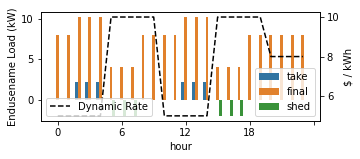

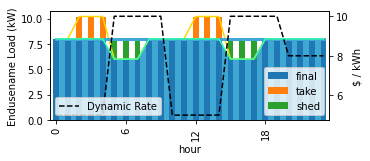

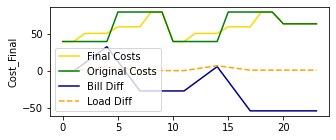

,orig,take,final,shed,hour,Cost_Orig,Cost_Final,Cost_Diff,Load_Diff
0,8,0.0,8.0,-0.0,0,40,40.0,0.0,0.0
1,8,0.0,8.0,-0.0,1,40,40.0,0.0,0.0
2,8,2.2,10.2,-0.0,2,40,51.0,11.0,2.2
3,8,2.2,10.2,-0.0,3,40,51.0,22.0,4.4
4,8,2.2,10.2,-0.0,4,40,51.0,33.0,6.6
5,8,0.0,6.0,2.0,5,80,60.0,13.0,4.6
6,8,0.0,6.0,2.0,6,80,60.0,-7.0,2.6
7,8,0.0,6.0,2.0,7,80,60.0,-27.0,0.6
8,8,0.0,8.0,-0.0,8,80,80.0,-27.0,0.6
9,8,0.0,8.0,-0.0,9,80,80.0,-27.0,0.6


<function __main__.cost_analysis(one_day, shift_schedule, enduse, price)>

In [143]:
enduse = 'EndUseName'
day_slice = slice(0,24)

demand = [8 for x in range(24)]
demand_df = pd.DataFrame.from_dict({enduse: demand})

price = [5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 8, 8, 8, 8]
price_df = pd.DataFrame.from_dict({'Total': price})

tech = {
    'rte': .9,
    'shift_window': 3,
    'base_load_frac': .25,
    'shift_direction': 'before',
}

shift_schedule = Basic_Shifter.get_shift_schedule(demand_df, day_slice, enduse, tech, price_df)

take_hour = 0
shed_hour = 0

#plot_load_vs_price(cluster, day_slice, enduse)
plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df)
plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df, balance_take_shed=True)
plot_cost(demand_df, shift_schedule, enduse, price_df)

In [98]:
shift_schedule.loc[14, 'final']

10.2

17 14 final_rte, price_difference -0.6000000000000001 5 rating 4.4
16 13 final_rte, price_difference -0.6000000000000001 5 rating 4.4
16 14 final_rte, price_difference -0.4 5 rating 4.6
15 12 final_rte, price_difference -0.6000000000000001 5 rating 4.4
15 13 final_rte, price_difference -0.4 5 rating 4.6
15 14 final_rte, price_difference -0.2 5 rating 4.8
7 4 final_rte, price_difference -0.6000000000000001 5 rating 4.4
6 3 final_rte, price_difference -0.6000000000000001 5 rating 4.4
6 4 final_rte, price_difference -0.4 5 rating 4.6
5 2 final_rte, price_difference -0.6000000000000001 5 rating 4.4
5 3 final_rte, price_difference -0.4 5 rating 4.6
5 4 final_rte, price_difference -0.2 5 rating 4.8


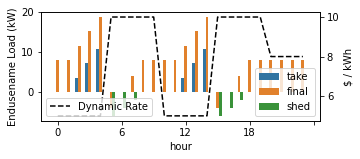

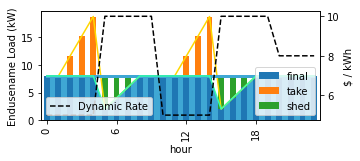

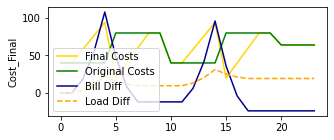

,orig,take,final,shed,hour,Cost_Orig,Cost_Final,Cost_Diff,Load_Diff
0,8,0.0,8.0,-0.0,0,40,40.0,0.0,0.0
1,8,0.0,8.0,-0.0,1,40,40.0,0.0,0.0
2,8,3.6,11.6,-0.0,2,40,58.0,18.0,3.6
3,8,7.2,15.2,-0.0,3,40,76.0,54.0,10.8
4,8,10.8,18.8,-0.0,4,40,94.0,108.0,21.6
5,8,0.0,2.0,6.0,5,80,20.0,48.0,15.6
6,8,0.0,4.0,4.0,6,80,40.0,8.0,11.6
7,8,0.0,6.0,2.0,7,80,60.0,-12.0,9.6
8,8,0.0,8.0,-0.0,8,80,80.0,-12.0,9.6
9,8,0.0,8.0,-0.0,9,80,80.0,-12.0,9.6


hour     23.0
orig      8.0
shed      0.0
take      0.0
final     8.0
Name: 23, dtype: float64

In [161]:
enduse = 'EndUseName'
day_slice = slice(0,24)

demand = [8 for x in range(24)]
demand_df = pd.DataFrame.from_dict({enduse: demand})

price = [5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 8, 8, 8, 8]
price_df = pd.DataFrame.from_dict({'Total': price})

tech = {
    'rte': .2,
    'shift_window': 3,
    'base_load_frac': .25,
    'shift_direction': 'before',
}

shift_schedule = Basic_Shifter.get_shift_schedule(demand_df, day_slice, enduse, tech, price_df)

take_hour = 0
shed_hour = 0

#plot_load_vs_price(cluster, day_slice, enduse)
plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df)
plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df, balance_take_shed=True)
plot_cost(demand_df, shift_schedule, enduse, price_df)

shift_schedule.iloc[-1]


16 13 final_rte, price_difference -1.5 2 rating 0.5
ceil
15 13 final_rte, price_difference -1.0 2 rating 1.0
ceil
14 13 final_rte, price_difference -0.5 2 rating 1.5
ceil
13 10 final_rte, price_difference -1.5 3 rating 1.5
ceil
12 10 final_rte, price_difference -1.0 4 rating 3.0
ceil
11 10 final_rte, price_difference -0.5 5 rating 4.5
ceil
10.666666666666668
8.0
8.0
2.666666666666667


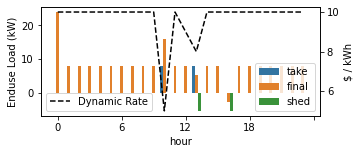

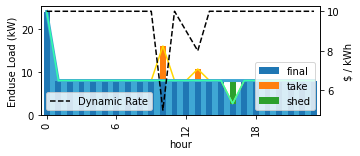

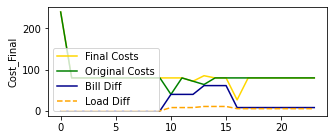

,orig,take,final,shed,hour,Cost_Orig,Cost_Final,Cost_Diff,Load_Diff
0,24,0,24.000000,-0.000000,0,240,240.000000,0.000000,0.000000
1,8,0,8.000000,-0.000000,1,80,80.000000,0.000000,0.000000
2,8,0,8.000000,-0.000000,2,80,80.000000,0.000000,0.000000
3,8,0,8.000000,-0.000000,3,80,80.000000,0.000000,0.000000
4,8,0,8.000000,-0.000000,4,80,80.000000,0.000000,0.000000
5,8,0,8.000000,-0.000000,5,80,80.000000,0.000000,0.000000
6,8,0,8.000000,-0.000000,6,80,80.000000,0.000000,0.000000
7,8,0,8.000000,-0.000000,7,80,80.000000,0.000000,0.000000
8,8,0,8.000000,-0.000000,8,80,80.000000,0.000000,0.000000
9,8,0,8.000000,-0.000000,9,80,80.000000,0.000000,0.000000


<function __main__.cost_analysis(one_day, shift_schedule, enduse, price)>

In [162]:
enduse = 'EndUse'
day_slice = slice(0,24)

demand = [24]
demand.extend([8 for x in range(23)])
demand_df = pd.DataFrame.from_dict({enduse: demand})

price = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 10, 9, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
price_df = pd.DataFrame.from_dict({'Total': price})

tech = {
    'rte': .5,
    'shift_window': 3,
    'base_load_frac': 1,
    'shift_direction': 'before',
}
shift_schedule = Basic_Shifter.get_shift_schedule(demand_df, day_slice, enduse, tech, price_df)
print(shift_schedule.loc[13, 'final']) 
print(shift_schedule.loc[14, 'final']) 
print(shift_schedule.loc[15, 'final']) 
print(shift_schedule.loc[16, 'final'])

plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df)
plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df, balance_take_shed=True)
plot_cost(demand_df, shift_schedule, enduse, price_df)

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

{}

/home/mstuebs/code/cpuc-dynamic-pricing/10_bottom_up_shift/Tech_Models/basicshifter.py:36: RuntimeWarning: divide by zero encountered in long_scalars
  price_difference = prices.loc[shed_hour, 'Total'] / prices.loc[take_hour, 'Total']


{}

{}

{}

{}

8
8
8
8


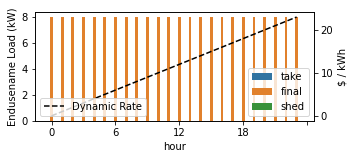

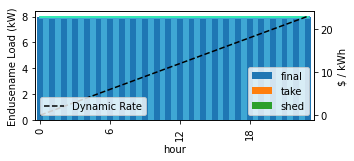

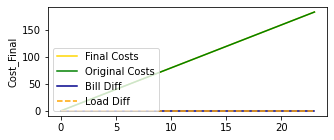

,orig,take,final,shed,hour,Cost_Orig,Cost_Final,Cost_Diff,Load_Diff
0,8,0,8,0,0,0,0,0,0
1,8,0,8,0,1,8,8,0,0
2,8,0,8,0,2,16,16,0,0
3,8,0,8,0,3,24,24,0,0
4,8,0,8,0,4,32,32,0,0
5,8,0,8,0,5,40,40,0,0
6,8,0,8,0,6,48,48,0,0
7,8,0,8,0,7,56,56,0,0
8,8,0,8,0,8,64,64,0,0
9,8,0,8,0,9,72,72,0,0


<function __main__.cost_analysis(one_day, shift_schedule, enduse, price)>

In [145]:
enduse = 'EndUseName'
day_slice = slice(0,24)

demand = [8 for x in range(24)]
demand_df = pd.DataFrame.from_dict({enduse: demand})

price = [i for i in range(24)]
price_df = pd.DataFrame.from_dict({'Total': price})

tech = {
    'rte': .1,
    'shift_window': 3,
    'base_load_frac': 1,
    'shift_direction': 'before',
}
shift_schedule = Basic_Shifter.get_shift_schedule(demand_df, day_slice, enduse, tech, price_df)
print(shift_schedule.loc[13, 'final']) 
print(shift_schedule.loc[14, 'final']) 
print(shift_schedule.loc[15, 'final']) 
print(shift_schedule.loc[16, 'final'])

plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df)
plot_current_action(demand_df, shift_schedule, enduse, take_hour, shed_hour, price_df, balance_take_shed=True)
plot_cost(demand_df, shift_schedule, enduse, price_df)